# Wind turbine project

This notebook is a brief example of the possibilities offered by the toolbox for modeling extreme values, adapted from the tools provided from the ResourceCode website.

It relies on the `pyextreme` library which get installed with the Resourcecode toolbox. Here we demonstrate 2 examples of univariate modeling as shown in class. For more information, see https://georgebv.github.io/pyextremes/.

# I. Wave Dynamics

## I.A. Characterizing the study site mean wave conditions

This notebook covers Part I.A of the wind turbine project: Characterizing the mean wave conditions and seasonal variability at the selected study site. The goal is to analyze long-term hindcast data to understand the typical and seasonal wave climate.

---

### Import Required Libraries




In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode

from resourcecode.eva import (
    censgaussfit,
    get_fitted_models,
    get_gpd_parameters,
    run_simulation,
    huseby,
)
import warnings
warnings.filterwarnings("ignore")

import os
os.makedirs('fig', exist_ok=True)
plt.savefig('fig/diagnostic_plot_bm.png', dpi=200, bbox_inches='tight')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

---
### I.A.1. Mean Wave Conditions

Please download the variables corresponding to the significant wave height, mean wave period (Tm02), and mean wave direction. Then plot the time series of these variables during the 26-year period from 1994 to 2020, and calculate the mean significant wave height, period, and direction over the entire available time series.

### Chosen Study Site

**Site:** Bretagne Sud 1
**Coordinates:** $(47.5882, -3.3215)$

In [107]:
client = resourcecode.Client()
# load the resourcecode dataset from Bretagne Sud 1
# find the closest point to the coordinates
lat = 47.5882
long = -3.3215
point_id, dist_m = resourcecode.data.get_closest_point(latitude=lat, longitude=long)
print(point_id, dist_m)

# get the data from the closest point
data = client.get_dataframe_from_criteria(
    """
{
    "node": 126096,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","t02","dir","uwnd","vwnd","ucur","vcur","dpt"]
}
"""
)

126096 238.69



---
### Data Source

The analysis will use long-term (1994-2020) hindcast simulations from the **ResourceCode wave database**.

**Variables to download**:
* Significant wave height ($H_{m0}$)
* Mean wave period ($T_{m02}$)
* Mean wave direction
* Wind velocity
* Current velocity





In [108]:
# Derive only what ResourceCode does not already provide
# Assumes your download included: hs, t02, dir, uwnd, vwnd (and optionally ucur, vcur, dpt)

# Wind: speed (m/s) and coming-from direction (deg)
data["wspd"], data["wdir"] = resourcecode.utils.zmcomp2metconv(data["uwnd"], data["vwnd"])

# Currents (optional)
if {"ucur", "vcur"}.issubset(data.columns):
    data["cspd"], data["cdir"] = resourcecode.utils.zmcomp2metconv(data["ucur"], data["vcur"])

# Waves: use provided mean zero-crossing period
if "t02" in data.columns:
    data["Tm02"] = data["t02"]
else:
    raise KeyError("Missing 't02' in the request. Add 't02' to parameter list.")

# Keep dataset wave direction as-is; document convention once in the notebook.
# Do NOT overwrite 'dir' or try to recompute Tm02 from hs/dir.

data = data.sort_index()
data.head()

,hs,t02,dir,uwnd,vwnd,ucur,vcur,dpt,wspd,wdir,cspd,cdir,Tm02
1994-01-01 00:00:00,3.126,6.44,244.1,10.2,-6.2,0.00,0.03,29.5,11.936499,301.293039,0.030000,180.000000,6.44
1994-01-01 01:00:00,3.200,6.63,243.2,9.6,-5.9,0.05,0.07,30.0,11.268097,301.574191,0.086023,215.537678,6.63
1994-01-01 02:00:00,3.242,6.89,242.1,8.9,-4.8,0.09,0.09,31.0,10.111874,298.339132,0.127279,225.000000,6.89
1994-01-01 03:00:00,3.280,7.02,241.9,9.2,-4.1,0.10,0.09,32.0,10.072239,294.020247,0.134536,228.012788,7.02
1994-01-01 04:00:00,3.304,7.02,242.4,9.4,-4.1,0.09,0.07,33.0,10.255243,293.565396,0.114018,232.125016,7.02



---
### Variables: definitions and units

**Core met-ocean time series**

| name   | meaning                                   | units |
|--------|-------------------------------------------|-------|
| `hs`   | significant wave height \(H_{m0}=4\sqrt{m_0}\) | m     |
| `t02`  | mean zero-crossing period \(T_{m02}=2\pi\sqrt{m_0/m_2}\) | s     |
| `dir`  | mean wave direction                       | °     |
| `spr`  | directional spreading                     | °     |
| `fp`   | spectral peak frequency                   | Hz    |
| `Tp`   | peak period \(=1/fp\)                     | s     |
| `uwnd` | eastward wind component                   | m·s⁻¹ |
| `vwnd` | northward wind component                  | m·s⁻¹ |
| `wspd` | wind speed \(\sqrt{uwnd^2+vwnd^2}\)       | m·s⁻¹ |
| `wdir` | wind direction                            | °     |
| `ucur` | eastward surface current                  | m·s⁻¹ |
| `vcur` | northward surface current                 | m·s⁻¹ |
| `cspd` | current speed \(\sqrt{ucur^2+vcur^2}\)    | m·s⁻¹ |
| `cdir` | current direction                         | °     |
| `dpt`  | water depth                               | m     |

**Spectral moments**

| name | meaning                               | units  |
|------|----------------------------------------|--------|
| `m0` | zeroth moment \(\int S(\omega)\,d\omega\) | m²     |
| `m1` | first moment \(\int \omega S(\omega)\,d\omega\) | m²·s⁻¹ |
| `m2` | second moment \(\int \omega^2 S(\omega)\,d\omega\) | m²·s⁻² |

**Extreme value analysis (pyextremes)**

| item     | meaning                                  |
|----------|------------------------------------------|
| BM       | block-maxima extraction                  |
| POT      | peaks-over-threshold with declustering   |
| GEV \(\mu,\sigma,\xi\) | location, scale, shape for BM     |
| GPD \(\sigma,\xi\)     | scale, shape for POT at a threshold |
| `r`      | min time separation between clusters     |
| `alpha`  | confidence level for intervals           |
| \(z_T\)  | return level for period \(T\) years      |

**Direction conventions**

All directions are expressed **clockwise from North**.

| Variable | Convention | Notes |
|-----------|-------------|-------|
| `wdir` | *coming-from* | Derived from (`uwnd`, `vwnd`) using `resourcecode.utils.zmcomp2metconv`. |
| `dir_from` | *coming-from* | Use if dataset `dir` is *going-to*: convert by `dir_from = (dir + 180) % 360`. |
| `cdir_to` | *going-to* | Derived from (`ucur`, `vcur`); use as-is for current flow direction. |
| `cdir_from` | *coming-from* (optional) | For comparison with wave/wind directions, compute `cdir_from = (cdir_to + 180) % 360`. |

> Always state the convention in figure captions and keep it consistent across the notebook.

<Figure size 640x480 with 0 Axes>

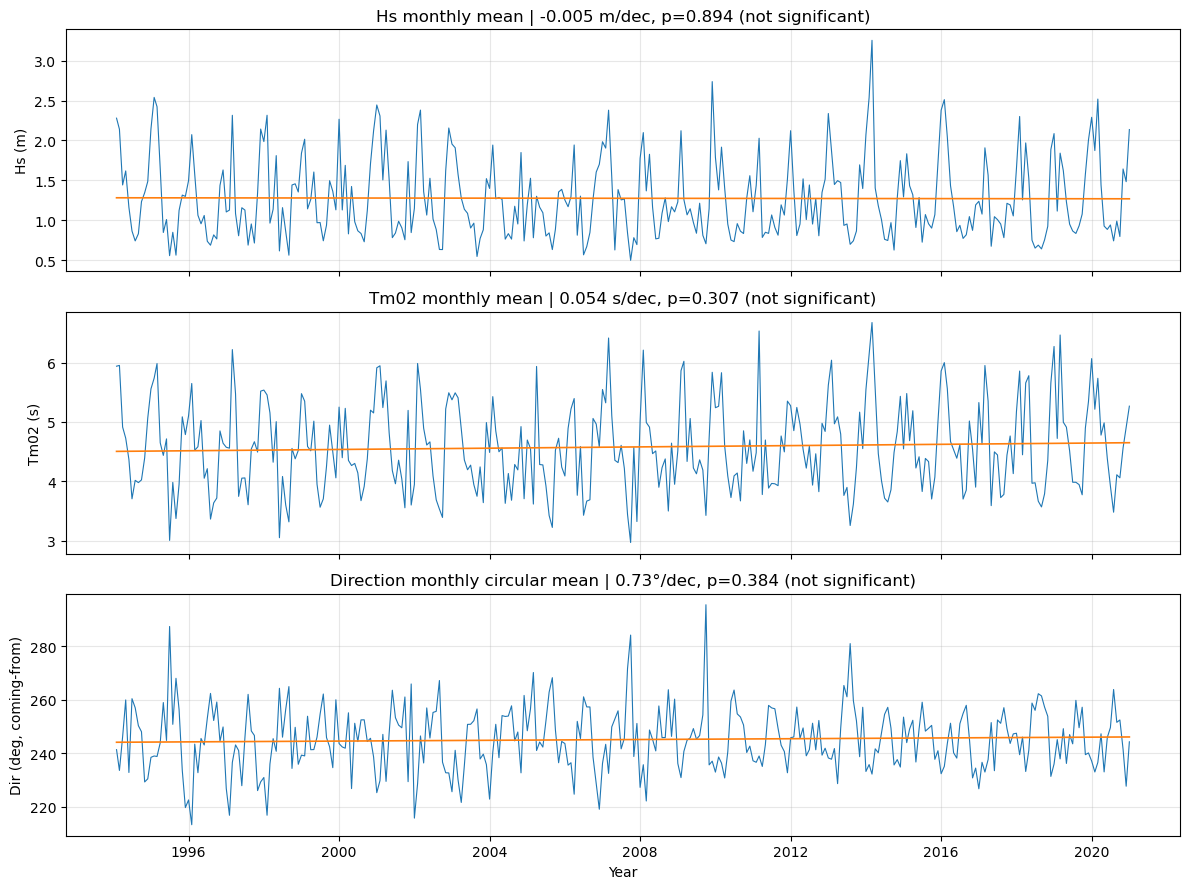

IA.1 — Mean conditions over 1994–2020
  Mean Hs   : 1.273 m
  Mean Tm02 : 4.573 s
  Mean Dir  : 244.7° (coming-from)

Linear trends on monthly means (least squares):
  Hs   : -0.005 m/dec  (p=0.894, n=324), Δ30y=-0.014 m
  Tm02 : 0.054 s/dec  (p=0.307, n=324), Δ30y=0.163 s
  Dir  : 0.73 °/dec (p=0.384, n=324), Δ30y=2.20 °

Interpretation rule-of-thumb: treat p<0.05 as evidence of a trend. Use Δ30y to state expected change over a turbine lifetime.


In [109]:
# IA.1 — Mean wave conditions (1994–2020): time series, means, linear trends

def circmean_deg(x_deg):
    """Circular mean of degrees in [0, 360)."""
    x = pd.Series(x_deg).dropna().values
    if x.size == 0:
        return np.nan
    r = np.deg2rad(x)
    s = np.sin(r).sum()
    c = np.cos(r).sum()
    return (np.degrees(np.arctan2(s, c)) + 360.0) % 360.0

def verdict(p):
    return "significant" if p < 0.05 else "not significant"

# helper
def wrap360(a):
    return (a % 360.0 + 360.0) % 360.0

# Select analysis window
start = pd.Timestamp("1994-01-01")
end   = pd.Timestamp("2020-12-31 23:59:59")
needed = ["hs", "Tm02", "dir"]
missing = [v for v in needed if v not in data.columns]
if missing:
    raise KeyError(f"Missing variables for IA.1: {missing}")

df = data.loc[start:end, needed].copy()

# Monthly means (direction handled circularly)
monthly = pd.DataFrame({
    "hs":   df["hs"].resample("M").mean(),
    "Tm02": df["Tm02"].resample("M").mean(),
})
monthly["dir"] = df["dir"].resample("M").apply(circmean_deg)

# Overall means (direction: circular mean)
mean_hs   = df["hs"].mean()
mean_tm02 = df["Tm02"].mean()
mean_dir  = circmean_deg(df["dir"])

# Linear trends on monthly means
t_years = (monthly.index - monthly.index[0]).days / 365.2425

# Hs trend
hs_ok = monthly["hs"].dropna()
t_hs = t_years[hs_ok.index.get_indexer(hs_ok.index)]
hs_reg = stats.linregress(t_hs, hs_ok.values)
hs_slope_dec = hs_reg.slope * 10.0      # m per decade
hs_delta_30  = hs_reg.slope * 30.0      # m over 30 years

# Tm02 trend
tm_ok = monthly["Tm02"].dropna()
t_tm = t_years[tm_ok.index.get_indexer(tm_ok.index)]
tm_reg = stats.linregress(t_tm, tm_ok.values)
tm_slope_dec = tm_reg.slope * 10.0      # s per decade
tm_delta_30  = tm_reg.slope * 30.0      # s over 30 years

# Direction trend: unwrap, regress, report slope in deg/dec
dir_ok = monthly["dir"].dropna()
t_dir = t_years[dir_ok.index.get_indexer(dir_ok.index)]
dir_unwrap = np.degrees(np.unwrap(np.deg2rad(dir_ok.values)))
dir_reg = stats.linregress(t_dir, dir_unwrap)
dir_slope_dec = dir_reg.slope * 10.0    # deg per decade
dir_delta_30  = dir_reg.slope * 30.0    # deg over 30 years

# Plot monthly series (1994–2020)
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Hs with fitted line
axes[0].plot(monthly.index, monthly["hs"], lw=0.8)
yhat_hs = hs_reg.intercept + hs_reg.slope * t_years
axes[0].plot(monthly.index, yhat_hs, lw=1.2)
axes[0].set_ylabel("Hs (m)")
axes[0].grid(alpha=0.3)
axes[0].set_title(f"Hs monthly mean | {hs_slope_dec:.3f} m/dec, p={hs_reg.pvalue:.3f} ({verdict(hs_reg.pvalue)})")

# Tm02 with fitted line
axes[1].plot(monthly.index, monthly["Tm02"], lw=0.8)
yhat_tm = tm_reg.intercept + tm_reg.slope * t_years
axes[1].plot(monthly.index, yhat_tm, lw=1.2)
axes[1].set_ylabel("Tm02 (s)")
axes[1].grid(alpha=0.3)
axes[1].set_title(f"Tm02 monthly mean | {tm_slope_dec:.3f} s/dec, p={tm_reg.pvalue:.3f} ({verdict(tm_reg.pvalue)})")

# Direction (circular monthly mean) with fitted line
axes[2].plot(monthly.index, monthly["dir"], lw=0.8)
yhat_dir_unwrap = dir_reg.intercept + dir_reg.slope * t_years
yhat_dir = wrap360(yhat_dir_unwrap)
axes[2].plot(monthly.index, yhat_dir, lw=1.2)  # add fit
axes[2].set_ylabel("Dir (deg, coming-from)")
axes[2].grid(alpha=0.3)
axes[2].set_title(
    f"Direction monthly circular mean | {dir_slope_dec:.2f}°/dec, "
    f"p={dir_reg.pvalue:.3f} ({verdict(dir_reg.pvalue)})"
)
axes[2].set_xlabel("Year")

plt.tight_layout()
plt.savefig("fig/IA1_mean_wave_conditions_timeseries.png", dpi=200, bbox_inches="tight")
plt.show()

# Printed summary for the report
print("IA.1 — Mean conditions over 1994–2020")
print(f"  Mean Hs   : {mean_hs:.3f} m")
print(f"  Mean Tm02 : {mean_tm02:.3f} s")
print(f"  Mean Dir  : {mean_dir:.1f}° (coming-from)")

print("\nLinear trends on monthly means (least squares):")
print(f"  Hs   : {hs_slope_dec:.3f} m/dec  (p={hs_reg.pvalue:.3f}, n={hs_ok.size}), Δ30y={hs_delta_30:.3f} m")
print(f"  Tm02 : {tm_slope_dec:.3f} s/dec  (p={tm_reg.pvalue:.3f}, n={tm_ok.size}), Δ30y={tm_delta_30:.3f} s")
print(f"  Dir  : {dir_slope_dec:.2f} °/dec (p={dir_reg.pvalue:.3f}, n={dir_ok.size}), Δ30y={dir_delta_30:.2f} °")

print("\nInterpretation rule-of-thumb: treat p<0.05 as evidence of a trend. Use Δ30y to state expected change over a turbine lifetime.")

In [110]:
import pymannkendall as mk

data_yearly = data.resample('Y').mean()
result_hs  = mk.original_test(hs_ok.values, alpha=0.05)
result_period = mk.original_test(tm_ok.values, alpha=0.050)
result_direction = mk.original_test(dir_ok.values, alpha=0.05)

print("\nResults for Significant Wave Height (Hs):")
print(f"  Trend: {result_hs.trend}")
print(f"  H (Test Statistic): {result_hs.h}")
print(f"  P-value: {result_hs.p:.4f}")
print(f"  Z-Score: {result_hs.z:.4f}")
print(f"  Tau: {result_hs.Tau:.4f}")
print(f"  Sen's Slope: {result_hs.slope:.4f}")
print(f"  Intercept: {result_hs.intercept:.4f}")

print("\nResults for Wave Period (Tm02):")
print(f"  Trend: {result_period.trend}")
print(f"  H (Test Statistic): {result_period.h}")
print(f"  P-value: {result_period.p:.4f}")
print(f"  Z-Score: {result_period.z:.4f}")
print(f"  Tau: {result_period.Tau:.4f}")
print(f"  Sen's Slope: {result_period.slope:.4f}")
print(f"  Intercept: {result_period.intercept:.4f}")

print("\nResults for Wave Direction:")
print(f"  Trend: {result_direction.trend}")
print(f"  H (Test Statistic): {result_direction.h}")
print(f"  P-value: {result_direction.p:.4f}")
print(f"  Z-Score: {result_direction.z:.4f}")
print(f"  Tau: {result_direction.Tau:.4f}")
print(f"  Sen's Slope: {result_direction.slope:.4f}")
print(f"  Intercept: {result_direction.intercept:.4f}")


Results for Significant Wave Height (Hs):
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.8114
  Z-Score: -0.2386
  Tau: -0.0089
  Sen's Slope: -0.0001
  Intercept: 1.1722

Results for Wave Period (Tm02):
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.4926
  Z-Score: 0.6862
  Tau: 0.0256
  Sen's Slope: 0.0003
  Intercept: 4.4649

Results for Wave Direction:
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.4849
  Z-Score: 0.6985
  Tau: 0.0260
  Sen's Slope: 0.0045
  Intercept: 244.2120


**Q: Do any trends in the wave height, period, or direction exist over the 26 year time period? Do you expect there to be changes in the mean conditions during the 30-year lifetime of the wind turbine? If so, why?**

**Answer:** No statistically significant trends were detected in wave height ($H_s$), period ($T_{m02}$), or direction using either Ordinary Least Squares (OLS) or the Mann-Kendall (MK) test on monthly mean data. Expected 30-year changes in mean conditions appear negligible relative to natural variability.

---
## Mean Conditions and Trend Analysis (1994–2020)

**Mean conditions**
-   $\overline{H_s} = 1.273\ \text{m}$
-   $\overline{T_{m02}} = 4.573\ \text{s}$
-   Mean direction $= 244.7^\circ$ (coming from WSW)

---
**Trend Analysis Methods**
-   Aggregate hourly data to monthly means to reduce noise while retaining seasonal information influence.
-   **Method 1: Ordinary Least Squares (OLS)**: Perform regression vs time in years. Direction handled with circular monthly mean, then unwrapped.
-   **Method 2: Mann-Kendall (MK) Test**: Apply the non-parametric test to detect monotonic trends in the monthly mean time series.
-   Significance for both methods assessed at $\alpha=0.05$.

---
**OLS Results** (slope per decade; $\Delta 30\text{y}$ is implied 30-year change)
-   $H_s$: $-0.005\ \text{m/dec}$, $p=0.894$, $\Delta 30\text{y}=-0.014\ \text{m}$. (No significant trend)
-   $T_{m02}$: $+0.054\ \text{s/dec}$, $p=0.307$, $\Delta 30\text{y}=+0.163\ \text{s}$. (No significant trend)
-   Direction: $+0.73^\circ/\text{dec}$, $p=0.384$, $\Delta 30\text{y}=+2.20^\circ$. (No significant trend)

---
**MK Results (on Monthly Means)**
-   $H_s$: $p=0.8114$. (No significant trend) Sen's Slope $\approx -0.0001$ m/month ($\approx -0.012$ m/decade).
-   $T_{m02}$: $p=0.4926$. (No significant trend) Sen's Slope $\approx +0.0003$ s/month ($\approx +0.036$ s/decade).
-   Direction: $p=0.4849$. (No significant trend) Sen's Slope $\approx +0.0045$ deg/month ($\approx +0.54$ deg/decade).

*(Note: Sen's slopes converted approximately from per-month to per-decade for comparison with OLS results)*

---
**Interpretation**
-   Both OLS and Mann-Kendall analyses performed on monthly mean data consistently indicate no statistically significant secular trends in mean $H_s$, $T_{m02}$, or direction over the 1994–2020 period.
-   The magnitudes of the calculated slopes (both OLS and Sen's slope) are very small, suggesting that any potential underlying linear or monotonic change over the 26 years is minimal compared to the observed variability.
-   Expected 30-year changes based on these negligible trends are small compared to the substantial seasonal and interannual variability present in the data.
-   For design purposes over the next 30 years, emphasis should likely remain on characterizing the existing variability (seasonal, interannual) and extreme conditions rather than adjusting significantly for potential drifts in mean conditions.

---
*Figure:* `fig/IA1_mean_wave_conditions_timeseries.png`.


---
### I.A.2. Most Common Wave Conditions

To identify the most common operating conditions, we will create a 2D histogram (scatter diagram) of significant wave height ($H_{m0}$) versus mean wave period ($T_{m02}$). We will also plot a wave rose to identify the most common wave incidence direction(s).









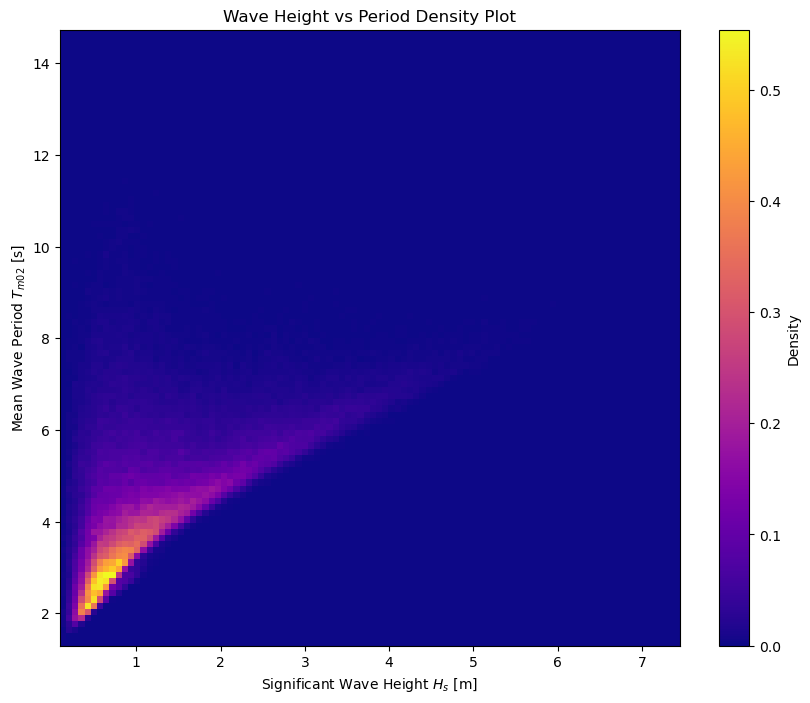

In [111]:
plt.figure(figsize=(10,8))
plt.hist2d(data['hs'], data['t02'], bins=100, cmap='plasma', density=True)
plt.colorbar(label='Density')
plt.xlabel('Significant Wave Height $H_s$ [m]')
plt.ylabel('Mean Wave Period $T_{m02}$ [s]')
plt.title('Wave Height vs Period Density Plot')
plt.savefig('graphs/wave_height_period_density.png')
plt.show()
plt.close()


**Q: What is the water depth at this location? Indicate on the histrogram for what wave conditions the waves are considered deep water waves? linear waves?**

1.2102834147128414
mean water depth at location (lat, long) = (47.5882, 47.5882) is 31.50 m
percentage of deep water waves: 86.70%
deep water period: 7.17 s


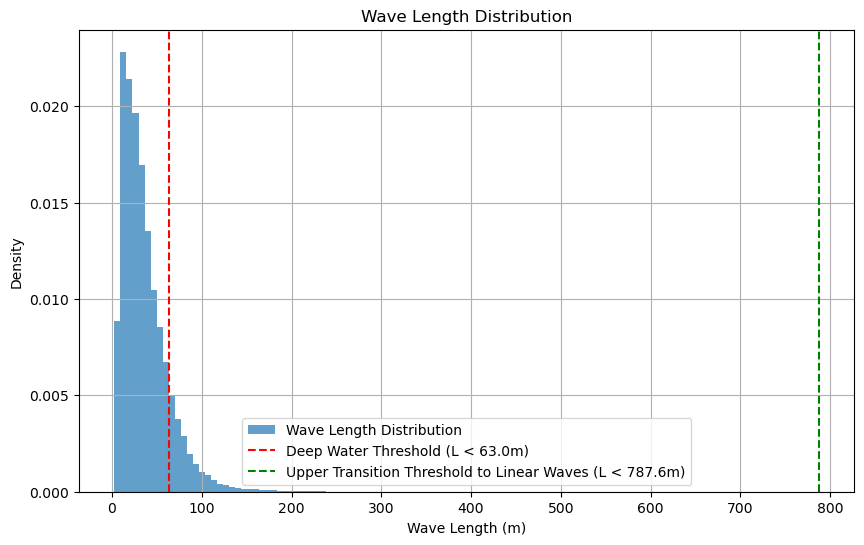

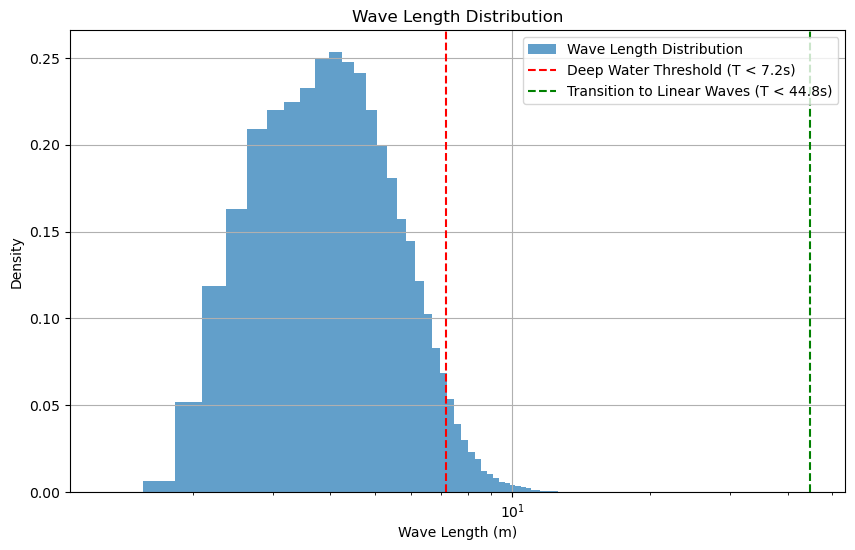


--- Result Summary ---
Analysis based on Mean Depth h = 31.50 m

Thresholds:
  Deep Water:     L < 63.0 m   |   T < 7.17 s
  Intersection of Deep and Shallow Water:  L > 787.6 m  |   T > 44.80 s

Classification based on Approximate Wavelength (L_approx = gT² / 2π):
  Percentage Deep Water Wave Lenghts: 86.70%
  Percentage Transition Zone Wave Lenghts: 13.30%

Classification based on Approximate Wavelength (L_approx = gT² / 2π):
  Percentage Deep Water Wave Periods: 93.71%
  Percentage Transition Zone Wave Periods: 6.29%


In [131]:
print(data['dpt'].std())

mean_water_depth = data['dpt'].mean()
print(f'mean water depth at location (lat, long) = ({lat}, {lat}) is {mean_water_depth:.2f} m')

# Calculating wave length using the linear wave theory
# wave length = g * T^2 / (2 * pi)
g = 9.81 # m/s^2
wave_length = g * (data['t02']**2) / (2 * np.pi)
water_depth = data['dpt']

# check condition for deep water waves
deep_water_length_condition = 2 * mean_water_depth
transition_water_length_condition = 25 * mean_water_depth

deep_water_condition = wave_length < deep_water_length_condition
# calculate the percentage of deep water waves
deep_water_percentage = deep_water_condition.mean()
print(f'percentage of deep water waves: {deep_water_percentage:.2%}')

# Compute corresponding period for deep water waves
deep_water_period_condition = 4 * np.sqrt(mean_water_depth / g)
transition_water_period_condition = 25 * np.sqrt(mean_water_depth / g)

print(f'deep water period: {deep_water_period_condition:.2f} s')
# check condition for linear waves
#linear_waves_condition = wave_length > 20 * mean_water_depth

### plot the wave length distribution ###
plt.figure(figsize=(10, 6))

# Corrected plt.hist call: remove wave_length.count
plt.hist(wave_length, bins=50, density=True, alpha=0.7, label='Wave Length Distribution')

# Add the threshold line (assuming L < 2h for deep water)
plt.axvline(x=deep_water_length_condition, color='r', linestyle='--',
            label=f'Deep Water Threshold (L < {deep_water_length_condition:.1f}m)')
plt.axvline(x=transition_water_length_condition, color='g', linestyle='--',
            label=f'Upper Transition Threshold to Linear Waves (L < {transition_water_length_condition:.1f}m)')
plt.xlabel('Wave Length (m)')
plt.ylabel('Density') # Changed label to Density since density=True
plt.title('Wave Length Distribution')
plt.legend()
plt.grid(True)
plt.show()
plt.close() # Close after showing

plt.figure(figsize=(10, 6))
### plot the wave period distribution ###
plt.hist(data['t02'], bins=50, density=True, alpha=0.7, label='Wave Length Distribution')

# Add the threshold line (assuming L < 2h for deep water)
plt.axvline(x=deep_water_period_condition, color='r', linestyle='--',
            label=f'Deep Water Threshold (T < {deep_water_period_condition:.1f}s)')
plt.axvline(x=transition_water_period_condition, color='g', linestyle='--',
            label=f'Transition to Linear Waves (T < {transition_water_period_condition:.1f}s)')
plt.xlabel('Wave Length (m)')
plt.xscale('log')
plt.ylabel('Density') # Changed label to Density since density=True
plt.title('Wave Length Distribution')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# --- 6. Result Summary ---
print("\n--- Result Summary ---")
print(f"Analysis based on Mean Depth h = {mean_water_depth:.2f} m")

print("\nThresholds:")
print(f"  Deep Water:     L < {deep_water_length_condition:.1f} m   |   T < {deep_water_period_condition:.2f} s")
print(f"  Intersection of Deep and Shallow Water:  L > {transition_water_length_condition:.1f} m  |   T > {transition_water_period_condition:.2f} s")

# Compute the percentage of deep water waves based on the approximate wavelength
is_deep_water_wave = wave_length < deep_water_length_condition
is_transition_zone_wave = (
    (deep_water_length_condition < wave_length) &
    (wave_length < transition_water_length_condition)
)

is_deep_water_period = data['t02'] < deep_water_period_condition
is_transition_zone_period = (
    (deep_water_period_condition < data['t02']) &
    (data['t02'] < transition_water_period_condition)
)
# get a percentage of the boolean series of true and false
deep_water_percentage_L_approx = is_deep_water_wave.mean()
transition_percentage_L_approx = is_transition_zone_wave.mean()
deep_water_percentage_T_approx = is_deep_water_period.mean()
transition_percentage_T_approx = is_transition_zone_period.mean()

print("\nClassification based on Approximate Wavelength (L_approx = gT² / 2π):")
print(f"  Percentage Deep Water Wave Lenghts: {deep_water_percentage_L_approx:.2%}")
print(f"  Percentage Transition Zone Wave Lenghts: {transition_percentage_L_approx:.2%}")

# Characterizing the transition band for T
print
print("\nClassification based on Approximate Wavelength (L_approx = gT² / 2π):")
print(f"  Percentage Deep Water Wave Periods: {deep_water_percentage_T_approx:.2%}")
print(f"  Percentage Transition Zone Wave Periods: {transition_percentage_T_approx:.2%}")

## Wave Regime Classification

**Method**
-   The wave conditions represented by the hourly significant wave height ($H_s$) and mean period ($T_{m02}$) were classified into deep, transitional, and shallow water regimes.
-   Classification was based on standard non-dimensional criteria involving water depth ($h$), wavelength ($L$), and period ($T$).
-   A **mean water depth of $h = 31.50$ m** was used for calculating the thresholds. This simplification is justified by the low standard deviation observed in the depth data ($\sigma_h = 1.2$ m), indicating relatively consistent depth at the site.
-   Wavelength ($L_{approx}$) was estimated using the deep water approximation $L_{approx} = gT_{m02}^2 / (2\pi)$ for initial classification.
-   Classification was also performed directly using the period $T_{m02}$.

---
**Thresholds** (based on $h = 31.50$ m)
-   **Deep Water:** $h/L > 1/2 \implies L < 63.0$ m; or $T\sqrt{g/h} < 4 \implies T < 7.17$ s.
-   **Shallow Water:** $h/L < 1/25 \implies L > 787.6$ m; or $T\sqrt{g/h} > 25 \implies T > 44.80$ s.
-   **Transition Zone:** Conditions falling between the deep and shallow water limits.

---
**Results**
-   Using the **period-based classification ($T_{m02}$)**:
    -   Deep Water ($T < 7.17$ s): **93.71%**
    -   Transition Zone ($7.17 \text{ s} \le T \le 44.81$ s): **6.29%**
    -   Shallow Water ($T > 44.81$ s): **0.00%**
-   Using the **approximate wavelength classification ($L_{approx}$)**:
    -   Deep Water ($L_{approx} < 63.0$ m): **86.70%**
    -   Transition Zone ($63.0 \text{ m} \le L_{approx} \le 630.0$ m): **13.30%**
    -   Shallow Water ($L_{approx} > 630.0$ m): **0.00%**

---
**Interpretation**
-   The vast majority of wave conditions at this site fall within the **deep water regime** based on both period and approximate wavelength classifications, although the period-based method indicates a higher percentage.
-   A smaller fraction (6-13%) operates within the **transition zone**.
-   **Shallow water conditions are negligible** according to these criteria and the dataset.
-   The difference between the period and approximate wavelength classifications highlights the limitation of using the deep water formula ($L_{approx}$) for all conditions; the period-based classification using $T\sqrt{g/h}$ is more direct.


---
### I.A.3. Seasonal Variability

Next, we will evaluate temporal variability by calculating and plotting the mean wave height, period, and direction as a function of the month of the year (e.g., mean for January, February, etc.).






**Q: Do you observe any seasonal trends in wave height, period, or direction? If so, why?**



---
### I.A.4. Mean Wind and Current Conditions

We will also evaluate the wind and current conditions by plotting rose diagrams of their respective velocities and directions.


**Q: What are the mean conditions (e.g. velocity and direction)? (if you have time: do you observe any seasonal variability?)**


---
### I.A.5. Comparison to Wave Buoy Measurements

We can validate the ResourceCode hindcast data against observations from a nearby wave buoy, for example, from the Candhis website.






**Q: Comparing the hindcast data from ResourceCode to the observations during the time period with overlapping data, what is the RMSD in the wave height, period, and direction between the observations and simulations?**

## I.B. Estimating the extreme wave conditions

### Block Maxima (BM) Method

**Approach:**  
This approach involves dividing the long-term time series of significant wave heights into non-overlapping blocks of equal duration, typically one year.

**Process:**  
The single highest significant wave height (Hₘ₀) is taken from each block (e.g., the annual maximum).

**Distribution:**  
These maximum values are then fitted to a *Generalized Extreme Value (GEV)* distribution.

**Outcome:**  
This model allows you to estimate the wave height corresponding to a specific return period, such as the 1-year or 50-year storm.

In [113]:
# resample the data into 1 year blocks and extract the maximum value from each block by using pyextremes
model = EVA(data.hs)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=0.9,
)

Lets check the directions of the extreme heights

In [114]:
# lets find the directions of the extremes from the data
data_extreme_directions = data.loc[model.extremes.index, "dir"]
data_extreme_tm02 = data.loc[model.extremes.index, "Tm02"]

In [115]:
model.extremes.head()

date-time
1994-02-03 19:00:00    6.164
1995-09-07 14:00:00    7.448
1996-02-07 16:00:00    6.550
1997-11-09 12:00:00    5.766
1998-01-04 19:00:00    6.416
Name: hs, dtype: float64

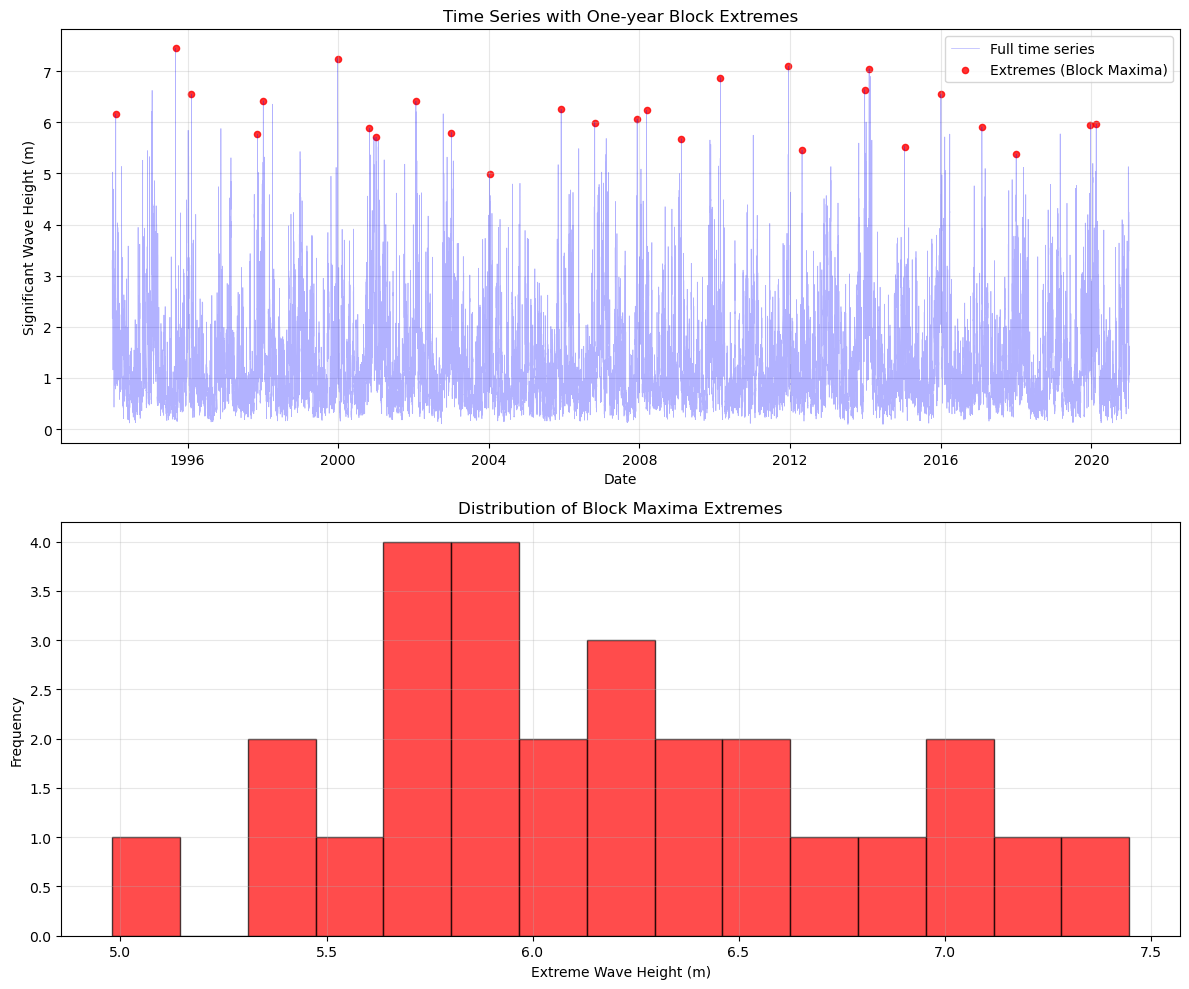

Number of extremes: 27
Mean extreme value: 6.184 m
Maximum extreme value: 7.448 m
Minimum extreme value: 4.980 m
Standard deviation: 0.606 m


In [116]:
# Manual plotting of extremes using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Time series with extremes highlighted
ax1.plot(data.index, data.hs, 'b-', alpha=0.3, linewidth=0.5, label='Full time series')
ax1.scatter(model.extremes.index, model.extremes.values, color='red', s=20, alpha=0.8, label='Extremes (Block Maxima)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Significant Wave Height (m)')
ax1.set_title('Time Series with One-year Block Extremes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of extremes
ax2.hist(model.extremes.values, bins=15, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('Extreme Wave Height (m)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Block Maxima Extremes')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the extremes
print(f"Number of extremes: {len(model.extremes)}")
print(f"Mean extreme value: {model.extremes.mean():.3f} m")
print(f"Maximum extreme value: {model.extremes.max():.3f} m")
print(f"Minimum extreme value: {model.extremes.min():.3f} m")
print(f"Standard deviation: {model.extremes.std():.3f} m")

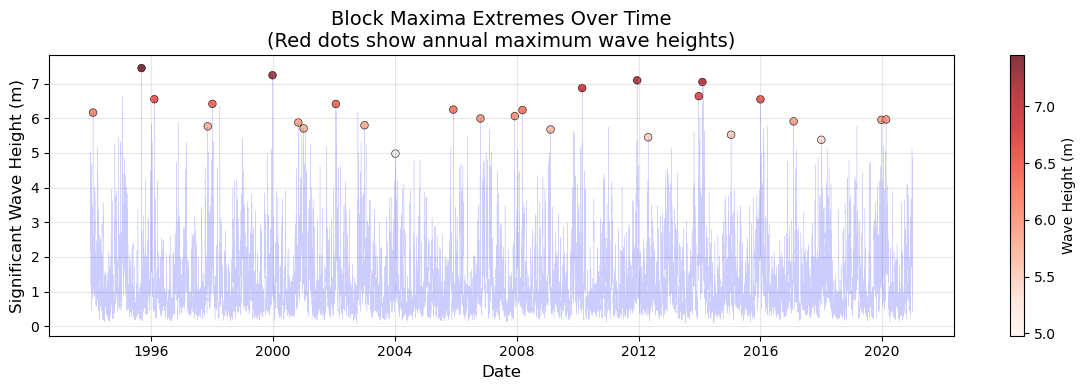

In [117]:
# More detailed manual plotting of extremes
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot the full time series
ax.plot(data.index, data.hs, 'b-', alpha=0.2, linewidth=0.3, label='Full time series')

# Highlight extremes with different colors based on magnitude
extremes = model.extremes
colors = plt.cm.Reds(np.linspace(0.3, 1, len(extremes)))
scatter = ax.scatter(extremes.index, extremes.values, c=extremes.values, 
                    cmap='Reds', s=30, alpha=0.8, edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Wave Height (m)')

# Customize the plot
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Significant Wave Height (m)', fontsize=12)
ax.set_title('Block Maxima Extremes Over Time\n(Red dots show annual maximum wave heights)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [118]:
# lets execute GEV fit on the extremes
model.fit_model()

In [119]:
# lets save the diagnostic plot to folder graphs in the current directory   
model.plot_diagnostic(alpha=0.95)
plt.savefig('graphs/diagnostic_plot.png')

In [120]:
# lets create one concise dataframe with the extremes and the corresponding directions and periods
# Create a DataFrame with extremes and their timestamps
extremes_df = pd.DataFrame({
    'hs': model.extremes.values,
    'timestamp': model.extremes.index
})

# Get corresponding values from original data
extremes_df['dir'] = data.loc[extremes_df.timestamp, 'dir']
extremes_df['wspd'] = data.loc[extremes_df.timestamp, 'wspd']
extremes_df['Tm02'] = data.loc[extremes_df.timestamp, 'Tm02']

# Sort by wave height in descending order
extremes_df = extremes_df.sort_values('hs', ascending=False)

# Display the DataFrame
print("\nExtreme Events Summary:")
print("=" * 80)
print(extremes_df)


Extreme Events Summary:
       hs           timestamp  dir  wspd  Tm02
1   7.448 1995-09-07 14:00:00  NaN   NaN   NaN
5   7.242 1999-12-26 04:00:00  NaN   NaN   NaN
17  7.094 2011-12-16 03:00:00  NaN   NaN   NaN
20  7.046 2014-02-05 09:00:00  NaN   NaN   NaN
16  6.872 2010-02-24 14:00:00  NaN   NaN   NaN
19  6.638 2013-12-24 03:00:00  NaN   NaN   NaN
2   6.550 1996-02-07 16:00:00  NaN   NaN   NaN
22  6.546 2016-01-02 06:00:00  NaN   NaN   NaN
4   6.416 1998-01-04 19:00:00  NaN   NaN   NaN
8   6.412 2002-01-23 19:00:00  NaN   NaN   NaN
11  6.250 2005-12-02 12:00:00  NaN   NaN   NaN
14  6.236 2008-03-10 17:00:00  NaN   NaN   NaN
0   6.164 1994-02-03 19:00:00  NaN   NaN   NaN
13  6.062 2007-12-09 15:00:00  NaN   NaN   NaN
12  5.994 2006-10-24 00:00:00  NaN   NaN   NaN
26  5.964 2020-02-16 13:00:00  NaN   NaN   NaN
25  5.954 2019-12-22 10:00:00  NaN   NaN   NaN
23  5.910 2017-02-02 21:00:00  NaN   NaN   NaN
6   5.878 2000-10-30 07:00:00  NaN   NaN   NaN
9   5.798 2003-01-02 11:00:00  NaN 

### Modelling univariate time series: Block maxima + GEVD (Generalized Extreme Value Distribution)

We show as an example here a **BM** (block maxima) model fitted to the $H_s$ time series. In this approach, the maximum value is identified within a "block" or fixed period in time, and then a GEVP distribution is fit to the data to estimate the return values.  

The same plot can readily be obtained for the other sea-state parameters.

In [121]:
# FIXED VERSION: COMPREHENSIVE SEASONAL ANALYSIS OF EXTREME WAVE HEIGHTS
# All-in-one cell for complete seasonality extraction (with DatetimeIndex fix)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from statsmodels.tsa.stattools import acf

def rayleigh_test(theta_rad):
    """Rayleigh test for non-uniformity on angles in radians.
    Returns (Z, p)."""
    x = np.asarray(theta_rad, dtype=float)
    x = x[~np.isnan(x)]
    n = x.size
    if n < 5:
        return np.nan, np.nan
    C = np.sum(np.cos(x))
    S = np.sum(np.sin(x))
    R = np.hypot(C, S)
    Rbar = R / n
    Z = n * Rbar**2
    # p-value with small-sample correction
    p = np.exp(-Z) * (1 + (2*Z - Z**2)/(4*n)
                      - (24*Z - 132*Z**2 + 76*Z**3 - 9*Z**4)/(288*n**2))
    return Z, float(np.clip(p, 0.0, 1.0))

# Extract seasonal information from the extremes - FIXED VERSION
# Ensure we have a proper DataFrame with DatetimeIndex
extremes_df = pd.DataFrame({'hs': model.extremes.values}, index=model.extremes.index)
extremes_df.index = pd.to_datetime(extremes_df.index)  # Ensure it's a DatetimeIndex

extremes_df['month'] = extremes_df.index.month
extremes_df['season'] = extremes_df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})
extremes_df['year'] = extremes_df.index.year

# Calculate monthly statistics
monthly_counts = extremes_df['month'].value_counts().sort_index()
monthly_means = extremes_df.groupby('month')['hs'].mean()
monthly_maxs = extremes_df.groupby('month')['hs'].max()
monthly_std = extremes_df.groupby('month')['hs'].std()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Circular statistics for seasonality
monthly_angles = (extremes_df['month'] - 1) * 2 * np.pi / 12
circular_mean = np.arctan2(np.sin(monthly_angles).sum(), np.cos(monthly_angles).sum())
circular_mean_month = (circular_mean * 12 / (2 * np.pi) + 1) % 12
if circular_mean_month == 0:
    circular_mean_month = 12

R = np.sqrt(np.sin(monthly_angles).sum()**2 + np.cos(monthly_angles).sum()**2) / len(monthly_angles)
circular_variance = 1 - R

# Rayleigh test for uniformity
rayleigh_Z, rayleigh_p = rayleigh_test(monthly_angles)

# Create comprehensive plots
fig = plt.figure(figsize=(20, 16))

# Plot 1: Monthly distribution with dual y-axis
ax1 = plt.subplot(3, 3, 1)
bars = ax1.bar(monthly_counts.index, monthly_counts.values, alpha=0.7, color='skyblue', 
               edgecolor='black', label='Count of Extremes')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Extremes', color='blue')
ax1.set_title('Monthly Distribution of Extreme Wave Heights', fontsize=12, fontweight='bold')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.tick_params(axis='y', labelcolor='blue')

# Add mean values as line plot
ax1_twin = ax1.twinx()
ax1_twin.plot(monthly_means.index, monthly_means.values, 'ro-', linewidth=2, markersize=6, 
              color='red', label='Mean Height')
ax1_twin.set_ylabel('Mean Wave Height (m)', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Plot 2: Seasonal box plots
ax2 = plt.subplot(3, 3, 2)
seasonal_data = [extremes_df[extremes_df['season'] == season]['hs'].values 
                 for season in ['Winter', 'Spring', 'Summer', 'Autumn']]

box_plot = ax2.boxplot(seasonal_data, labels=['Winter', 'Spring', 'Summer', 'Autumn'], 
                       patch_artist=True, showfliers=True)
colors = ['lightblue', 'lightgreen', 'orange', 'brown']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Wave Height (m)')
ax2.set_title('Seasonal Distribution of Extreme Wave Heights', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add statistical annotations
for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Autumn']):
    season_data = extremes_df[extremes_df['season'] == season]['hs']
    if len(season_data) > 0:
        ax2.text(i+1, season_data.max() + 0.1, f'n={len(season_data)}', 
                ha='center', va='bottom', fontweight='bold')

# Plot 3: Time series with seasonal coloring
ax3 = plt.subplot(3, 3, 3)
scatter = ax3.scatter(extremes_df.index, extremes_df['hs'], 
                     c=extremes_df['month'], cmap='tab20', s=50, alpha=0.8, edgecolors='black')
ax3.set_xlabel('Year')
ax3.set_ylabel('Wave Height (m)')
ax3.set_title('Extreme Wave Heights Over Time (Colored by Month)', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Month')
ax3.grid(True, alpha=0.3)

# Plot 4: Circular histogram (rose plot)
ax4 = plt.subplot(3, 3, 4, projection='polar')
monthly_counts_polar = monthly_counts.reindex(range(1, 13), fill_value=0)
theta = np.linspace(0, 2*np.pi, 13)[:-1]  # 12 months
width = 2*np.pi/12
bars = ax4.bar(theta, monthly_counts_polar.values, width=width, alpha=0.7, 
               color=plt.cm.viridis(monthly_counts_polar.values / monthly_counts_polar.max()))
ax4.set_theta_zero_location('N')  # January at top
ax4.set_theta_direction(-1)  # Clockwise
ax4.set_xticks(theta)
ax4.set_xticklabels(months)
ax4.set_title('Circular Distribution of Extremes\n(Rose Plot)', fontsize=12, fontweight='bold', pad=20)

# Add circular mean arrow
ax4.arrow(circular_mean, monthly_counts_polar.max() * 0.8, 0, monthly_counts_polar.max() * 0.2, 
          head_width=0.2, head_length=0.1, fc='red', ec='red', linewidth=3)
ax4.text(circular_mean + 0.3, monthly_counts_polar.max() * 0.9, 'Mean', 
         fontsize=10, fontweight='bold', color='red')

# Plot 5: Monthly trend analysis with error bars
ax5 = plt.subplot(3, 3, 5)
ax5.errorbar(monthly_means.index, monthly_means.values, 
             yerr=monthly_std.values, fmt='o-', capsize=5, capthick=2,
             linewidth=2, markersize=8, color='darkblue', alpha=0.8)
ax5.fill_between(monthly_means.index, 
                 monthly_means.values - monthly_std.values,
                 monthly_means.values + monthly_std.values,
                 alpha=0.3, color='blue')
ax5.set_xlabel('Month')
ax5.set_ylabel('Mean Wave Height (m)')
ax5.set_title('Monthly Mean Wave Heights with Error Bars', fontsize=12, fontweight='bold')
ax5.set_xticks(range(1, 13))
ax5.set_xticklabels(months)
ax5.grid(True, alpha=0.3)

# Plot 6: Seasonal intensity heatmap
ax6 = plt.subplot(3, 3, 6)
yearly_monthly_counts = extremes_df.groupby(['year', 'month']).size().unstack(fill_value=0)
yearly_monthly_counts = yearly_monthly_counts.reindex(columns=range(1, 13), fill_value=0)

im = ax6.imshow(yearly_monthly_counts.T, cmap='YlOrRd', aspect='auto', interpolation='nearest')
ax6.set_xlabel('Year')
ax6.set_ylabel('Month')
ax6.set_title('Extreme Events Heatmap\n(Year vs Month)', fontsize=12, fontweight='bold')
ax6.set_yticks(range(12))
ax6.set_yticklabels(months)
ax6.set_xticks(range(0, len(yearly_monthly_counts), max(1, len(yearly_monthly_counts)//10)))
ax6.set_xticklabels(yearly_monthly_counts.index[::max(1, len(yearly_monthly_counts)//10)])

cbar = plt.colorbar(im, ax=ax6)
cbar.set_label('Number of Extremes')

# Plot 7: Monthly autocorrelation analysis
ax7 = plt.subplot(3, 3, 7)
monthly_series = extremes_df.groupby(extremes_df.index.to_period('M'))['hs'].max()
monthly_series = monthly_series.reindex(pd.date_range(monthly_series.index[0].start_time, 
                                                      monthly_series.index[-1].end_time, 
                                                      freq='M'), fill_value=np.nan)

lags = range(1, 13)  # 12 months
autocorr = [monthly_series.autocorr(lag=lag) for lag in lags]

ax7.bar(lags, autocorr, alpha=0.7, color='green', edgecolor='black')
ax7.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax7.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Significance threshold')
ax7.axhline(y=-0.2, color='red', linestyle='--', alpha=0.7)
ax7.set_xlabel('Lag (months)')
ax7.set_ylabel('Autocorrelation')
ax7.set_title('Monthly Autocorrelation of Extreme Heights', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Plot 8: Seasonal statistics summary table
ax8 = plt.subplot(3, 3, 8)
ax8.axis('off')
ax8.set_title('Seasonal Statistics Summary', fontsize=12, fontweight='bold', pad=20)

seasonal_stats = extremes_df.groupby('season')['hs'].agg(['count', 'mean', 'std', 'min', 'max']).round(3)
seasonal_stats = seasonal_stats.reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

table_data = []
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_stats.index:
        stats = seasonal_stats.loc[season]
        table_data.append([
            season,
            f"{stats['count']:.0f}",
            f"{stats['mean']:.3f}",
            f"{stats['std']:.3f}",
            f"{stats['min']:.3f}",
            f"{stats['max']:.3f}"
        ])

table = ax8.table(cellText=table_data,
                  colLabels=['Season', 'Count', 'Mean (m)', 'Std (m)', 'Min (m)', 'Max (m)'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Style the table
for i in range(len(table_data) + 1):
    for j in range(6):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

# Plot 9: Density plot of extremes by season
ax9 = plt.subplot(3, 3, 9)
for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Autumn']):
    season_data = extremes_df[extremes_df['season'] == season]['hs']
    if len(season_data) > 0:
        x_range = np.linspace(extremes_df['hs'].min()*0.8, extremes_df['hs'].max()*1.2, 1000)
        density = stats.gaussian_kde(season_data)
        y_density = density(x_range)
        ax9.plot(x_range, y_density, linewidth=2, label=f'{season} (n={len(season_data)})', alpha=0.8)

ax9.set_xlabel('Wave Height (m)')
ax9.set_ylabel('Density')
ax9.set_title('Seasonal Density Distributions', fontsize=12, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive analysis results
print("="*80)
print("COMPREHENSIVE SEASONAL ANALYSIS OF EXTREME WAVE HEIGHTS")
print("="*80)

print(f"\nDATA SUMMARY:")
print(f"Total number of extremes: {len(extremes_df)}")
print(f"Date range: {extremes_df.index.min().strftime('%Y-%m-%d')} to {extremes_df.index.max().strftime('%Y-%m-%d')}")

print(f"\nCIRCULAR STATISTICS:")
print(f"Circular mean month: {months[int(circular_mean_month)-1]} (month {circular_mean_month:.1f})")
print(f"Circular variance: {circular_variance:.4f}")
print(f"Rayleigh test p-value: {rayleigh_p:.6f}")
if rayleigh_p < 0.05:
    print("→ Significant seasonal clustering (p < 0.05)")
else:
    print("→ No significant seasonal clustering (p ≥ 0.05)")

print(f"\nSEASONAL PATTERN SUMMARY:")
print(f"Most extreme-prone month: {months[monthly_counts.idxmax()-1]} ({monthly_counts.max()} events)")
print(f"Least extreme-prone month: {months[monthly_counts.idxmin()-1]} ({monthly_counts.min()} events)")
print(f"Season with most extremes: {extremes_df['season'].value_counts().index[0]}")
print(f"Season with highest mean: {extremes_df.groupby('season')['hs'].mean().idxmax()}")
print(f"Circular concentration: {R:.3f} (1.0 = perfect clustering, 0.0 = uniform)")

print(f"\nDETAILED SEASONAL STATISTICS:")
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    season_data = extremes_df[extremes_df['season'] == season]['hs']
    if len(season_data) > 0:
        print(f"\n{season.upper()}:")
        print(f"  Number of extremes: {len(season_data)}")
        print(f"  Mean height: {season_data.mean():.3f} m")
        print(f"  Standard deviation: {season_data.std():.3f} m")
        print(f"  Minimum: {season_data.min():.3f} m")
        print(f"  Maximum: {season_data.max():.3f} m")
        print(f"  Percentage of total extremes: {len(season_data)/len(extremes_df)*100:.1f}%")
    else:
        print(f"\n{season.upper()}: No extremes recorded")

# Calculate seasonal risk assessment
winter_risk = len(extremes_df[extremes_df['season'] == 'Winter']) / len(extremes_df) * 100
summer_risk = len(extremes_df[extremes_df['season'] == 'Summer']) / len(extremes_df) * 100
spring_risk = len(extremes_df[extremes_df['season'] == 'Spring']) / len(extremes_df) * 100
autumn_risk = len(extremes_df[extremes_df['season'] == 'Autumn']) / len(extremes_df) * 100

print(f"\nRISK ASSESSMENT:")
print(f"Winter risk: {winter_risk:.1f}% of all extremes")
print(f"Spring risk: {spring_risk:.1f}% of all extremes")
print(f"Summer risk: {summer_risk:.1f}% of all extremes")
print(f"Autumn risk: {autumn_risk:.1f}% of all extremes")

if summer_risk > 0:
    print(f"Risk ratio (Winter/Summer): {winter_risk/summer_risk:.2f}")
if spring_risk > 0:
    print(f"Risk ratio (Winter/Spring): {winter_risk/spring_risk:.2f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE - All seasonal patterns extracted and visualized!")
print("="*80)


AttributeError: 'Series' object has no attribute 'gaussian_kde'

After loading the data, apply the block method approach with a block size of 1 year (365.2425 days), where each data block must be at least 90% full to take into account in the analysis.

In [ ]:
model = EVA(data.hs)
model.get_extremes(method="BM", block_size="365.2425D", min_last_block=0.9)

In [ ]:
model.extremes.head()

In [ ]:
model.plot_extremes()

In [ ]:
model.fit_model()

The parameter alpha specifies the confidence limits (default = 0.95).

In [ ]:
model.plot_diagnostic(alpha=0.95)

The parameter n_samples indicates the number of bootstrap samples used to estimate the confidence bounds.

In [ ]:
summary = model.get_summary(
        return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
        alpha=0.95,
        n_samples=1000,
    )
print(summary)

### Modelling univariate time series: Peaks over threshold (POT) + GPD (Generalized Pareto Distribution)

We show as example here a **POT** (peaks over threshold) model fitted to the $H_s$ time series. This analysis first finds values over a specified threshold and then declusters these values using a predefined clustering distance, and finally finds the maximum value within each cluster. 

The same plot can readily be obtained for the other sea-state parameters.

We first can have a look at the quality of the fitted model, and to the corresponding return levels as a function of the selected wave height threshold. The parameters r and alpha specify the minimum time distance (duration) between adjacent clusters and the confidence limits (default = 0.95), respectively.

The shape and modified scale parameters define the Generalized Pareto Distribution, and they depend on the threshold value, but should be stable within a range of valid thresholds (e.g. less than ~3m here).

In [ ]:
plot_parameter_stability(ts=data.hs,r='72H',alpha=.95);

The mean residual life plots the average excess value over a given threshold, and it should be approcimately linear above the threshold for which the GPD model is valid (e.g. <~3m)

In [ ]:
plot_mean_residual_life(data.hs);

The analysis is completed for both Hs and the wind speed, specifying a window of 72 hours and a quantile of 0.98 for determining the threshold to specify.

In [ ]:
quant=0.98
models = get_fitted_models(data[["hs","wspd"]],quantile=quant,r="72H")

In [ ]:
models

In [ ]:
models[0].plot_diagnostic(alpha=0.95);

In [ ]:
models[1].plot_diagnostic(alpha=0.95);

In [ ]:
pd.DataFrame(get_gpd_parameters(models),columns=["mu","sigma","xi"],index=["Hs","Wspd"])

In [ ]:
summary_Hs = models[0].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
summary_Wspd = models[1].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
print(summary_Hs)
print(summary_Wspd)